In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from datetime import date

%matplotlib inline

In [2]:
# Initialize date range and delay threshold parameters
start_date = date(2017, 1, 1)
end_date = date(2017, 12, 31)
delay_threshold = 15

In [3]:
def get_monthly_flights_by_airport(start_date=date.min, end_date=date.max, delay_threshold=15):
    """ Return a dataframe flight counts by day of week and year  """
    engine = create_engine('sqlite:///./../../data/processed/airlines.db')
    
    with engine.connect() as conn:
        monthly_flights = pd.read_sql("""
            SELECT 
                f.origin_airport_id as airport_id,
                a.display_airport_name as airport_name,
                f.origin as origin_airport,
                f.month as month,
                f.year as year,
                SUM(f.flights) AS flights,
                SUM(f.departure_was_delayed_15) AS departure_delays,
                SUM(f.arrival_was_delayed_15) AS arrival_delays
            FROM 
                flights AS f
            JOIN
                airports as a
            ON
                f.origin_airport_id = a.airport_id
            WHERE 
                f.flight_date 
            BETWEEN :start_date 
                AND :end_date
            GROUP BY 
                f.month, f.year, f.origin
        """, conn, 
        params={'start_date': start_date, 'end_date': end_date})
    return monthly_flights

# Get summary data for selected date range, counting flights delayed more than 15 minutes on departure
monthly_flights_by_airport = get_monthly_flights_by_airport(start_date=start_date, end_date=end_date)
monthly_flights_by_airport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3551 entries, 0 to 3550
Data columns (total 8 columns):
airport_id          3551 non-null int64
airport_name        3551 non-null object
origin_airport      3551 non-null object
month               3551 non-null int64
year                3551 non-null int64
flights             3551 non-null int64
departure_delays    3551 non-null int64
arrival_delays      3551 non-null int64
dtypes: int64(6), object(2)
memory usage: 222.0+ KB


In [4]:
f = monthly_flights_by_airport.groupby(
        ['airport_name', 'origin_airport', 'year', 'airport_id']
    ).sum()[['flights', 'departure_delays', 'arrival_delays']]

f['fraction_delayed_on_departure'] = f['departure_delays'] / f['flights']
f['fraction_delayed_on_arrival'] = f['arrival_delays'] / f['flights']

f = f.sort_values('flights', ascending=False)
f.head(25)

,,,,flights,departure_delays,arrival_delays,fraction_delayed_on_departure,fraction_delayed_on_arrival
airport_name,origin_airport,year,airport_id,,,,,
Hartsfield-Jackson Atlanta International,ATL,2017,10397,1819775,322235,299605,0.177074,0.164638
Los Angeles International,LAX,2017,12892,1282614,297462,284640,0.231919,0.221922
Chicago O'Hare International,ORD,2017,13930,1063672,201628,216720,0.189558,0.203747
Dallas/Fort Worth International,DFW,2017,11298,723084,134472,148080,0.185970,0.204789
McCarran International,LAS,2017,12889,454095,96387,91380,0.212262,0.201235
Denver International,DEN,2017,11292,445250,79984,82482,0.179638,0.185249
Seattle/Tacoma International,SEA,2017,14747,410541,66096,72213,0.160997,0.175897
Baltimore/Washington International Thurgood Marshall,BWI,2017,10821,403136,75756,71208,0.187917,0.176635
George Bush Intercontinental/Houston,IAH,2017,12266,386907,57258,57219,0.147989,0.147888


In [5]:
total_flights = f['flights'].sum()
total_delays = f['departure_delays'].sum()
rate_of_delay = total_delays / total_flights

print("Total Domestic Departures (2017): ", "{:,}".format(total_flights))
print("Total Delayed Departures (2017):  ", "{:,}".format(total_delays))
print("Percent of Flights Delayed (2017): ", '{:5.2f}%'.format(rate_of_delay * 100))

Total Domestic Departures (2017):  17,131,449
Total Delayed Departures (2017):   3,097,726
Percent of Flights Delayed (2017):  18.08%


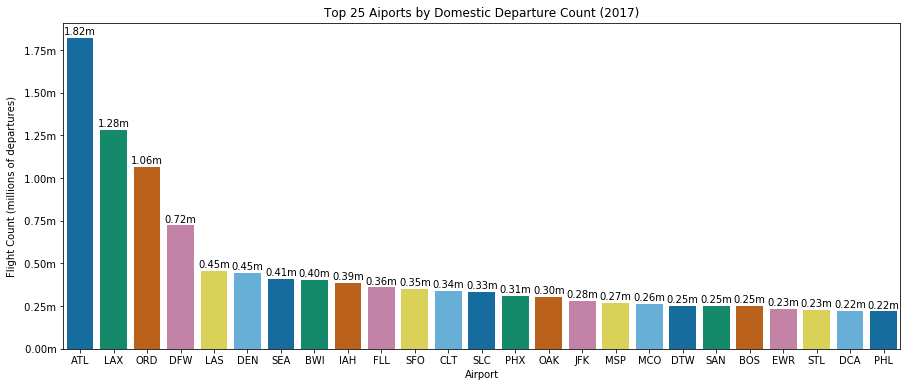

In [6]:
def plot_top_airports_flight_counts(plot_data):
    count = len(plot_data)
    ax, fig = plt.subplots(figsize=(15, 6))
    color = sns.color_palette('colorblind')
    
    ax = sns.barplot(x='origin_airport', y='flights', data=plot_data, palette=color)
    plt.title(f'Top {count} Aiports by Domestic Departure Count (2017)')
    #plt.xticks(rotation=90)
    plt.xlabel('Airport')
    plt.ylabel('Flight Count (millions of departures)')

    one_million = 1e6
    
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:5.2f}m'.format(x / one_million) for x in vals])
    
    for p in ax.patches:
        height = p.get_height()
        label_string = '{:2.2f}m'.format(height/one_million)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 0.02 * one_million,
                label_string,
                ha="center", color='black') 

    plt.show()
    
plot_top_airports_flight_counts(f.head(25).reset_index())

## Which airports manage the greatest volumes of departing domestic flights?

Based on 2017 BTS data, more than 17 million domestic flights departed from 3551 airports.  The airports who saw the greatest volume of those flights include Hartsfield Atlanta International - ATL (1.82m), Los Angeles International - LAX (1.28m), Chicago O'Hare International - ORD (1.06m) and Dallas/Fort Worth International - DFW (0.72m).

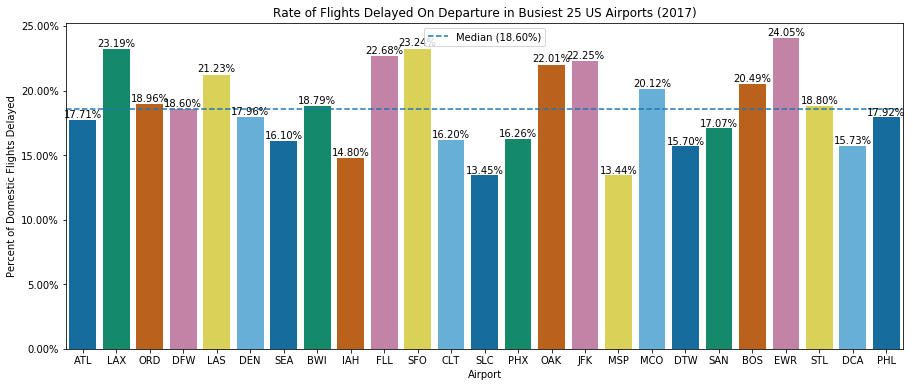

In [7]:
def plot_rates_of_delay(data):
    count = len(data)
    
    ax, fig = plt.subplots(figsize=(15, 6))
    color = sns.color_palette('colorblind')
    ax = sns.barplot(
        x='origin_airport', 
        y='fraction_delayed_on_departure', 
        data=data, 
        palette=color
    )
    plt.title(f'Rate of Flights Delayed On Departure in Busiest {count} US Airports (2017)')
    plt.xlabel('Airport')
    plt.ylabel('Percent of Domestic Flights Delayed')

    median = data['fraction_delayed_on_departure'].median()
    median_percent = '{:3.2f}%'.format(median * 100)
    hline = ax.axhline(
        y=data['fraction_delayed_on_departure'].median(), 
        xmin=0, 
        xmax=1, 
        linestyle='--', 
        label=f'Median ({median_percent})',
    )


    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
    
    for p in ax.patches:
        height = p.get_height()
        label_string = '{:3.2f}%'.format(height * 100)
        ax.text(p.get_x()+p.get_width()/2.,
                height * 1.01,
                label_string,
                ha="center", color='black') 
    
    plt.legend(handles=[hline], loc='upper center')
    plt.show()

plot_rates_of_delay(f.head(25).reset_index())

## Of the largest airports, what percentage of flights were delayed in 2017?

The rate of delays appears to vary greatly even among airports of similar size.  Newark (EWR), San Francisco (SFO), and Los Angeles (LAX) were the most frequently delayed among the largest 25 airports.  Salt Lake City (SLC) and Minneapolis-St.Paul was the least frequently delayed upon departure.

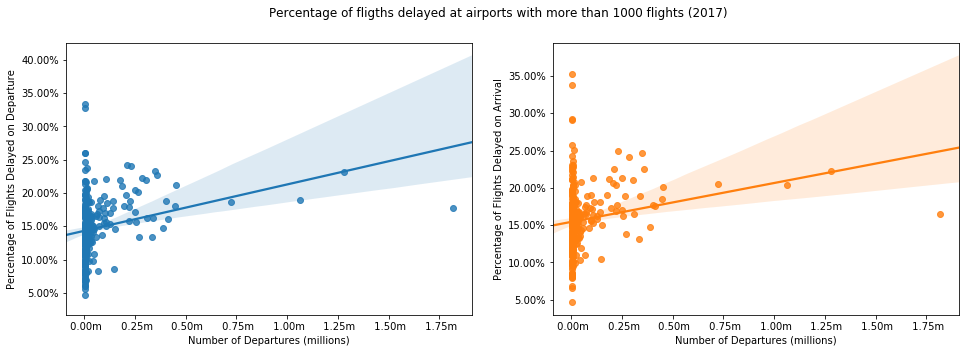

In [8]:
def plot_rates_of_delay_against_airport_size(data, minimum_flight_count=5000):
    d = data[data['flights'] > minimum_flight_count]

    a4_dims = (16, 5)
    color = sns.color_palette('colorblind')
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=a4_dims)

    _ = sns.regplot(data=d, x='flights', y='fraction_delayed_on_departure', fit_reg=True, ax=ax1)
    _ = ax1.set_ylabel('Percentage of Flights Delayed on Departure')

    _ = sns.regplot(data=d, x='flights', y='fraction_delayed_on_arrival', fit_reg=True, ax=ax2)
    _ = ax2.set_ylabel('Percentage of Flights Delayed on Arrival')

    _ = plt.suptitle(f"Percentage of fligths delayed at airports with more than {minimum_flight_count} flights (2017)")

    for ax in [ax1, ax2]:
        _ = ax.set_xlabel('Number of Departures (millions)')

        vals = ax.get_yticks()
        _ = ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])

        one_million = 1e6
        vals = ax.get_xticks()
        _ = ax.set_xticklabels(['{:5.2f}m'.format(x / one_million) for x in vals])

    plt.show()
    
plot_rates_of_delay_against_airport_size(f, 1000)

## How does the rate of delay vary with airport size?

Plotting the rate of delay against the number of departures does not indicate a strong relationship between airport size and the rates of delay.  This suggests that other factors may be better indicators of flight delays.